In [66]:
import os, glob
import numpy as np
import cv2
from os import listdir
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Activation,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras import backend as K
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from PIL import Image
from keras.applications import VGG19
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from keras.layers import BatchNormalization  
from keras.callbacks import EarlyStopping, ReduceLROnPlateau  

In [67]:
directory_root = '/Users/harsha/Downloads/archive/PlantVillage'

In [68]:
os.listdir(directory_root)

['Tomato_healthy',
 'Potato___Early_blight',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Early_blight',
 '.DS_Store',
 'Tomato__Target_Spot',
 'Potato___Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Septoria_leaf_spot',
 'Tomato__Tomato_mosaic_virus',
 'Pepper__bell___Bacterial_spot',
 'Tomato_Bacterial_spot',
 'Tomato_Late_blight',
 'Pepper__bell___healthy',
 'Potato___healthy']

# Importing Data

In [69]:

# empty listsare intitialized  to store file paths and labels
image_paths = []
class_labels = []

for root, dirs, files in os.walk(directory_root):
    for file in files:
        image_paths.append(os.path.join(root, file))
        class_labels.append(os.path.basename(os.path.normpath(root)))

# Creating a DataFrame
df = pd.DataFrame({'Image_Path': image_paths, 'Class_Label': class_labels})

# Shuffling the DF
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,Image_Path,Class_Label
0,/Users/harsha/Downloads/archive/PlantVillage/T...,Tomato__Tomato_YellowLeaf__Curl_Virus
1,/Users/harsha/Downloads/archive/PlantVillage/T...,Tomato_healthy
2,/Users/harsha/Downloads/archive/PlantVillage/T...,Tomato__Tomato_YellowLeaf__Curl_Virus
3,/Users/harsha/Downloads/archive/PlantVillage/P...,Pepper__bell___Bacterial_spot
4,/Users/harsha/Downloads/archive/PlantVillage/T...,Tomato_Spider_mites_Two_spotted_spider_mite


In [70]:
#Deleting unwanted data
df = df[df['Class_Label'] != 'PlantVillage']

df.reset_index(drop=True, inplace=True)

df.head()

,Image_Path,Class_Label
0,/Users/harsha/Downloads/archive/PlantVillage/T...,Tomato__Tomato_YellowLeaf__Curl_Virus
1,/Users/harsha/Downloads/archive/PlantVillage/T...,Tomato_healthy
2,/Users/harsha/Downloads/archive/PlantVillage/T...,Tomato__Tomato_YellowLeaf__Curl_Virus
3,/Users/harsha/Downloads/archive/PlantVillage/P...,Pepper__bell___Bacterial_spot
4,/Users/harsha/Downloads/archive/PlantVillage/T...,Tomato_Spider_mites_Two_spotted_spider_mite


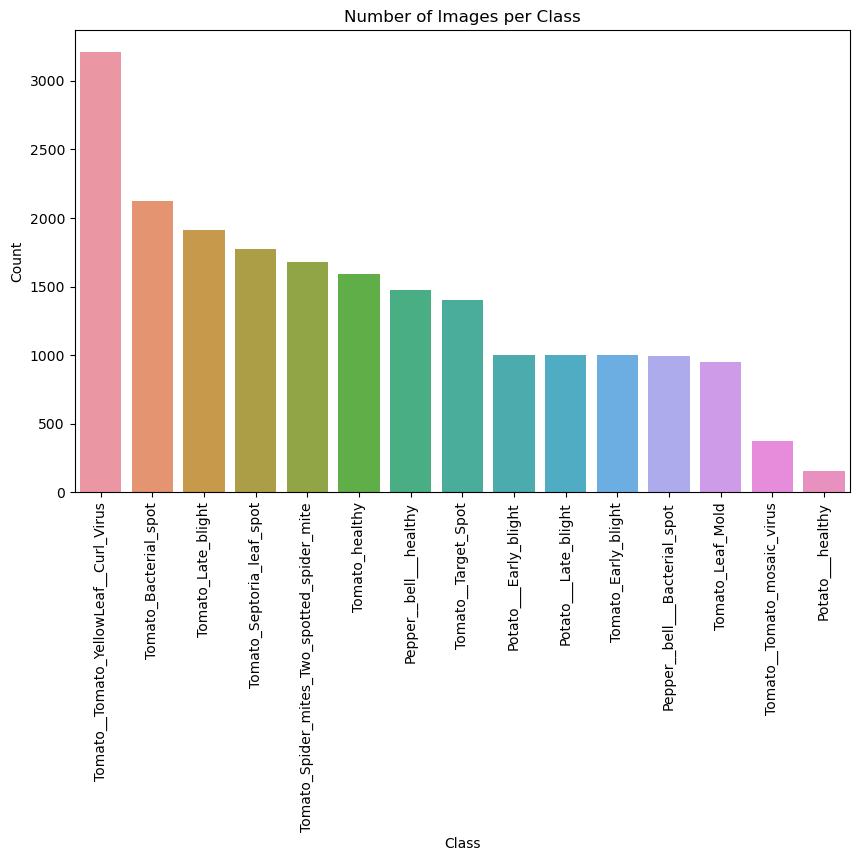

Number of classes: 15


In [71]:

class_counts = df['Class_Label'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=90)
plt.show()
num_classes = len(class_counts)
print(f"Number of classes: {num_classes}")

# Visualizing the Imported Data

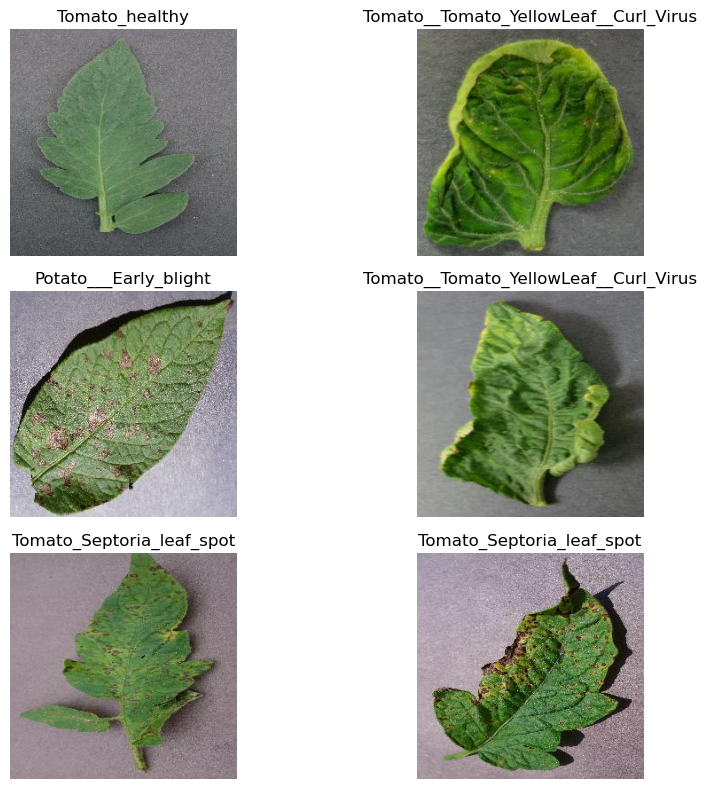

In [72]:
def show_images(data, num_images=6, grid_size=(3, 2)):
    indices = random.sample(range(len(data)), num_images)

    
    fig, axes = plt.subplots(*grid_size, figsize=(10, 8))

    
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        
        img = Image.open(data.iloc[idx]['Image_Path'])

        # Display the image
        axes[i].imshow(np.array(img))
        axes[i].set_title(data.iloc[idx]['Class_Label'])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_images(df)

In [73]:
# Taking half of the data set because of huge data and It is taking Lot of time to Build the model.

df = df.sample(frac=0.5, random_state=42)  

In [74]:
train_df,test_df=train_test_split(df,test_size=0.2, random_state=42)

# Image Augmentation

In [75]:
def create_data_generators(train_df, test_df):


  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      validation_split=0.2,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )
  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  # Checking  for class imbalance before creating generators
  class_counts = train_df['Class_Label'].value_counts().sort_values(ascending=False)
  print("Class Distribution:")
  print(class_counts)


  train_gen = train_datagen.flow_from_dataframe(
      dataframe=train_df,
      x_col='Image_Path',
      y_col='Class_Label',
      target_size=(100, 100),
      class_mode='categorical',
      batch_size=32,
      shuffle=True,
      seed=42
  )
    
  valid_gen = train_datagen.flow_from_dataframe(
      dataframe=train_df,
      x_col='Image_Path',
      y_col='Class_Label',
      target_size=(100, 100),
      class_mode='categorical',
      batch_size=32,
      shuffle=False,
      seed=42
  )

  test_gen = test_datagen.flow_from_dataframe(
      dataframe=test_df,
      x_col='Image_Path',
      y_col='Class_Label',
      target_size=(100, 100),
      class_mode='categorical',
      batch_size=32,
      shuffle=False
  )

  return train_gen, valid_gen, test_gen

train_generator, validation_generator, test_generator = create_data_generators(train_df, test_df)



Class Distribution:
Class_Label
Tomato__Tomato_YellowLeaf__Curl_Virus          1277
Tomato_Bacterial_spot                           849
Tomato_Late_blight                              736
Tomato_Septoria_leaf_spot                       711
Tomato_healthy                                  677
Tomato_Spider_mites_Two_spotted_spider_mite     653
Pepper__bell___healthy                          613
Tomato__Target_Spot                             573
Tomato_Early_blight                             404
Pepper__bell___Bacterial_spot                   400
Potato___Early_blight                           396
Potato___Late_blight                            376
Tomato_Leaf_Mold                                375
Tomato__Tomato_mosaic_virus                     155
Potato___healthy                                 61
Name: count, dtype: int64
Found 8255 validated image filenames belonging to 15 classes.
Found 8255 validated image filenames belonging to 15 classes.
Found 2064 validated image filenames b

/Users/harsha/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="Image_Path". These filename(s) will be ignored.
  warnings.warn(
/Users/harsha/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="Image_Path". These filename(s) will be ignored.
  warnings.warn(


In [76]:

# # Define number of classes for output layer
# num_classes = 15  # Replace with your actual number of classes

# Loading  the pre-trained VGG19 model without top layers
pretrained_model = VGG19(weights='imagenet', include_top=False, input_shape=(100, 100, 3))


#All layers of the pre-trained model are Freezed 
for layer in pretrained_model.layers:
  layer.trainable = False

# Add an output layer with "softmax" activation to predict multiple categories.
x = pretrained_model.output
x = Flatten()(x)
output = Dense(num_classes, activation='softmax')(x)

# Use the pre-trained model as the foundation to create the final model.
model = Model(inputs=pretrained_model.input, outputs=output)

optimizer = Adam(learning_rate=0.001)  
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │        69,135 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,093,519 (76.65 MB)

 Trainable params: 69,135 (270.06 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [77]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    min_delta=0,              
    patience=2,               
    mode='auto'               
)

In [78]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    callbacks=[early_stopping]  
)


Epoch 1/5


/Users/harsha/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


258/258 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.4408 - loss: 6.9765 - val_accuracy: 0.6764 - val_loss: 3.1684
Epoch 2/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 692s 3s/step - accuracy: 0.6750 - loss: 3.1203 - val_accuracy: 0.7381 - val_loss: 2.7802
Epoch 3/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 854s 3s/step - accuracy: 0.7427 - loss: 2.6721 - val_accuracy: 0.7267 - val_loss: 2.9330
Epoch 4/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 854s 3s/step - accuracy: 0.7464 - loss: 2.6958 - val_accuracy: 0.7626 - val_loss: 2.6227
Epoch 5/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 628s 2s/step - accuracy: 0.7639 - loss: 2.6911 - val_accuracy: 0.7874 - val_loss: 2.1926


In [80]:
model.save("my_model11.h5")

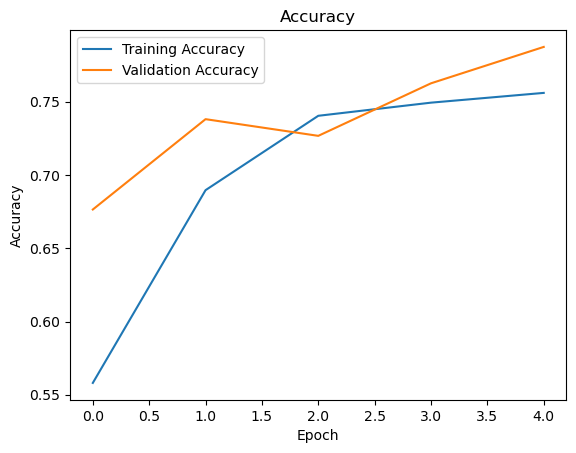

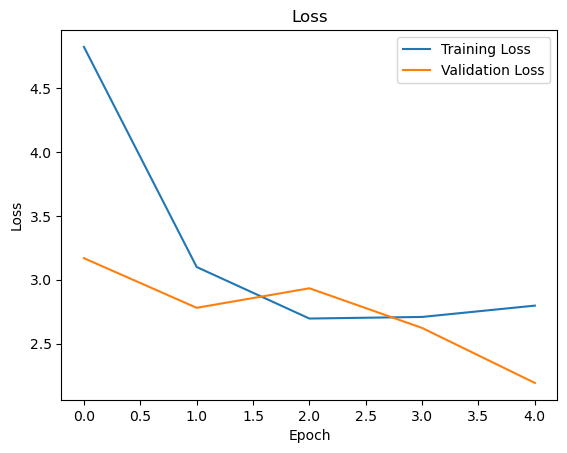

In [81]:

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [82]:
test_predictions = model.predict(test_generator)
predicted_labels = np.argmax(test_predictions, axis=1)

# Get the class indices from the training generator
class_indices = train_generator.class_indices

# Create a dictionary mapping class indices to class labels
class_labels = {index: label for label, index in class_indices.items()}

# Convert predicted indices to class labels
predicted_classes = [class_labels[index] for index in predicted_labels]

65/65 ━━━━━━━━━━━━━━━━━━━━ 46s 705ms/step


In [83]:
from sklearn.metrics import  classification_report

true_labels = list(test_df.Class_Label)
print("Number of true labels:", len(true_labels))

# Calculate the number of predicted labels
num_predicted_labels = len(predicted_classes)
print("Number of predicted labels:", num_predicted_labels)

# Generate classification report
report = classification_report(true_labels, predicted_classes)
print("Classification Report:")
print(report)

Number of true labels: 2064
Number of predicted labels: 2064
Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.83      0.82      0.82       103
                     Pepper__bell___healthy       0.91      0.91      0.91       144
                      Potato___Early_blight       0.90      0.85      0.88       103
                       Potato___Late_blight       0.84      0.79      0.81       119
                           Potato___healthy       0.57      1.00      0.72        13
                      Tomato_Bacterial_spot       0.95      0.77      0.85       219
                        Tomato_Early_blight       0.71      0.55      0.62       110
                         Tomato_Late_blight       0.82      0.75      0.78       187
                           Tomato_Leaf_Mold       0.66      0.84      0.74       116
                  Tomato_Septoria_leaf_spot       0.80      0.71 

In [84]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_classes)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.7916666666666666


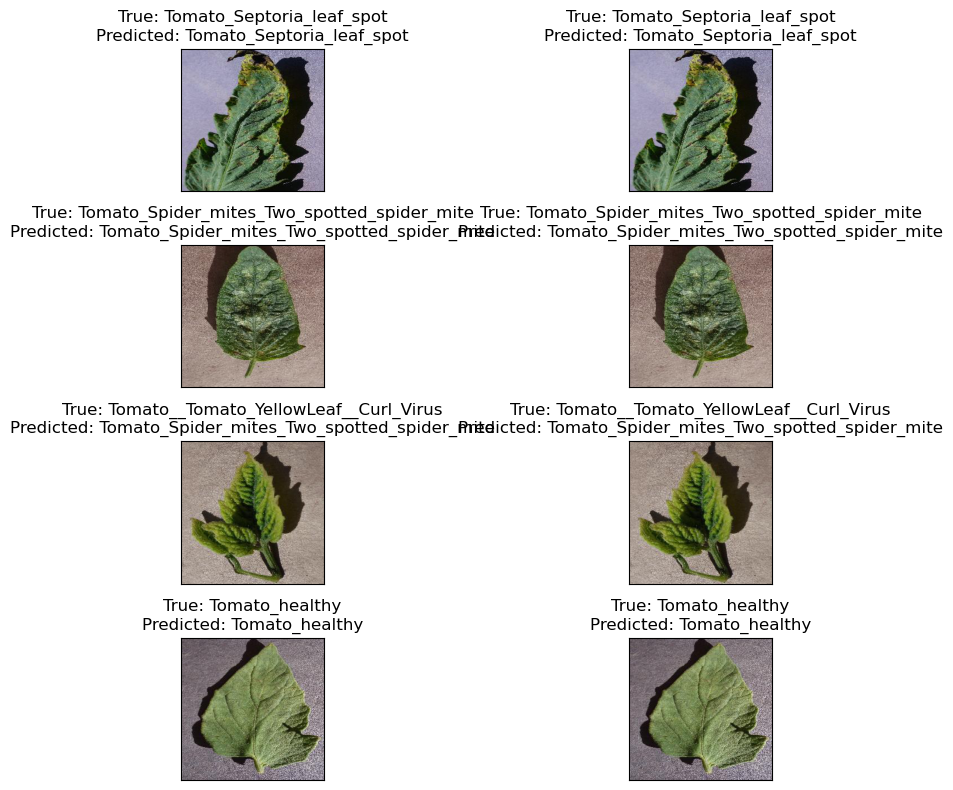

In [85]:
num_rows = 4
num_cols = 2
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    
    index = i // num_cols

    # Load and display the image
    image_path = test_df.Image_Path.iloc[index]
    image = plt.imread(image_path)
    ax.imshow(image)

    # Set the subplot title with true and predicted labels
    true_label = test_df.Class_Label.iloc[index]
    predicted_label = predicted_classes[index]
    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}")


plt.tight_layout()
plt.show()



# Performance Improvement

In [86]:



pretrained_model = VGG19(weights='imagenet', include_top=False, input_shape=(100, 100, 3))


for layer in pretrained_model.layers:
  layer.trainable = False

# After flattening the pre-trained features, add BatchNormalization.
x = pretrained_model.output
x = Flatten()(x)
x = BatchNormalization()(x)  


output = Dense(num_classes, activation='softmax')(x)

# Create the final model using the pre-trained model as the base
model2 = Model(inputs=pretrained_model.input, outputs=output)

# Compile the model with Adam optimizer and categorical crossentropy loss
optimizer = Adam(learning_rate=0.001)  
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


model2.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4608)           │        18,432 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,111,951 (76.72 MB)

 Trainable params: 78,351 (306.06 KB)

 Non-trainable params: 20,033,600 (76.42 MB)

In [87]:
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, mode='auto')

# Reduce learning rate on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.0001)  # Adjust parameters as needed


In [88]:
my_callbacks = [early_stopping, reduce_lr]

# Train the model with callbacks

In [89]:
history = model2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,  
    callbacks=my_callbacks
)

Epoch 1/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.5113 - loss: 1.6161 - val_accuracy: 0.7449 - val_loss: 0.8401 - learning_rate: 0.0010
Epoch 2/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 463s 2s/step - accuracy: 0.7405 - loss: 0.8058 - val_accuracy: 0.7843 - val_loss: 0.7241 - learning_rate: 0.0010
Epoch 3/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - accuracy: 0.7729 - loss: 0.7034 - val_accuracy: 0.8094 - val_loss: 0.6779 - learning_rate: 0.0010
Epoch 4/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - accuracy: 0.7879 - loss: 0.6666 - val_accuracy: 0.8187 - val_loss: 0.5998 - learning_rate: 0.0010
Epoch 5/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.7904 - loss: 0.6660 - val_accuracy: 0.8184 - val_loss: 0.6099 - learning_rate: 0.0010


In [90]:
model2.save("my_model12.h5")

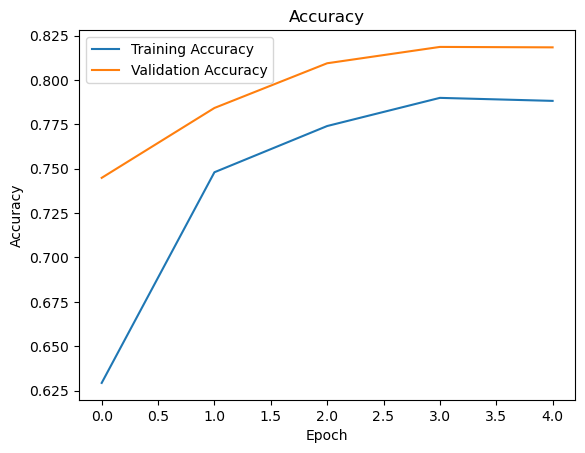

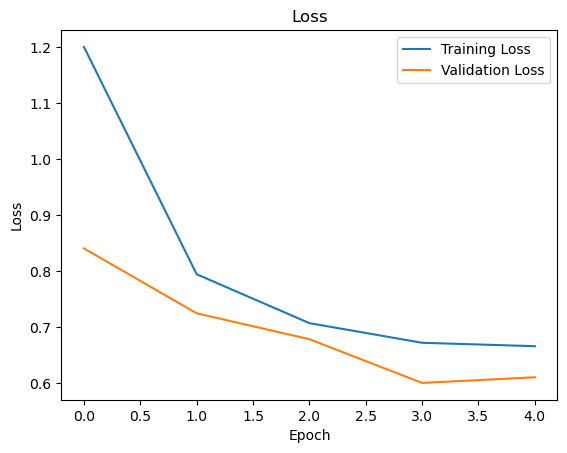

In [91]:

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [93]:
test_predictions = model2.predict(test_generator)
predicted_labels = np.argmax(test_predictions, axis=1)

# Get the class indices from the training generator
class_indices = train_generator.class_indices

# Create a dictionary mapping class indices to class labels
class_labels = {index: label for label, index in class_indices.items()}

# Convert predicted indices to class labels
predicted_classes = [class_labels[index] for index in predicted_labels]

65/65 ━━━━━━━━━━━━━━━━━━━━ 47s 719ms/step


In [94]:
from sklearn.metrics import  classification_report

true_labels = list(test_df.Class_Label)
print("Number of true labels:", len(true_labels))

# Calculate the number of predicted labels
num_predicted_labels = len(predicted_classes)
print("Number of predicted labels:", num_predicted_labels)

# Generate classification report
report = classification_report(true_labels, predicted_classes)
print("Classification Report:")
print(report)

Number of true labels: 2064
Number of predicted labels: 2064
Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.92      0.79      0.85       103
                     Pepper__bell___healthy       0.86      0.97      0.92       144
                      Potato___Early_blight       0.91      0.91      0.91       103
                       Potato___Late_blight       0.91      0.82      0.86       119
                           Potato___healthy       0.87      1.00      0.93        13
                      Tomato_Bacterial_spot       0.91      0.88      0.89       219
                        Tomato_Early_blight       0.73      0.58      0.65       110
                         Tomato_Late_blight       0.87      0.73      0.79       187
                           Tomato_Leaf_Mold       0.83      0.69      0.75       116
                  Tomato_Septoria_leaf_spot       0.75      0.85 

In [95]:

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_classes)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8226744186046512


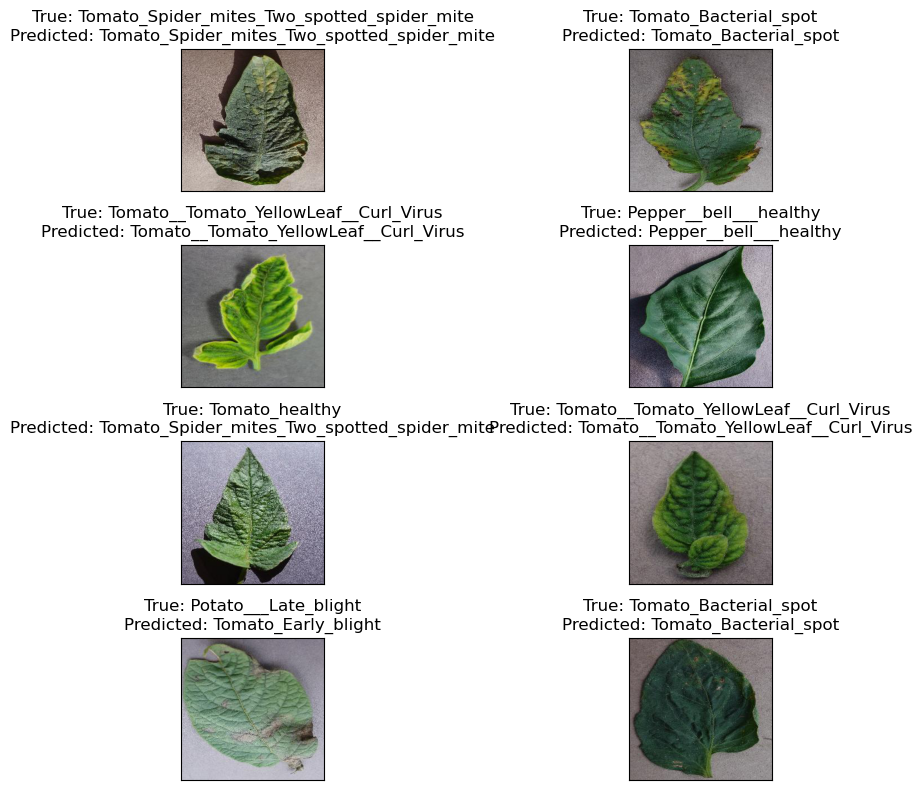

In [98]:
import random


num_rows = 4
num_cols = 2


fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8),
                         subplot_kw={'xticks': [], 'yticks': []})

total_images = len(test_df)

random_indices = random.sample(range(total_images), num_rows * num_cols)

for i, ax in enumerate(axes.flat):
  
    index = random_indices[i]


    image_path = test_df.Image_Path.iloc[index]
    image = plt.imread(image_path)
    ax.imshow(image)

    true_label = test_df.Class_Label.iloc[index]
    predicted_label = predicted_classes[index]
    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()
